# Chapter 13 - Dimensionality Reduction (Chain of Tasks)

In [3]:
## needed libs
! pip install transformers


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [12]:
# General Python Libs
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# SKlearn Models
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler,Normalizer,MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity

# Clustering algorithms
## GaussianMixture
from sklearn.mixture import GaussianMixture
## KMeans
from sklearn.cluster import KMeans
# pytorch models
import torch


# Tokenizers
from transformers import AutoTokenizer, AutoModel
# Bert Model
from transformers import BertTokenizer, BertModel

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

In [6]:
# to privent SSL error while loading locally
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
df_papers = pd.read_csv("https://raw.githubusercontent.com/umassdgithub/DataViz-Fall2024/refs/heads/main/Week-8-ForceSimulator/data/data_scopus.csv")

# 1. Text Classification (Term Frequency)
## Textual field of the Academic Papers database

In [7]:
df_papers[['EID','Title','Abstract']].head(3)

,EID,Title,Abstract
0,2-s2.0-85086464158,Virtual reality applications for the built env...,With its advanced capabilities of immersive an...
1,2-s2.0-85082875828,"Self-tracking while doing sport: Comfort, moti...",The spread of wearable technologies is paving ...
2,2-s2.0-85078194587,"Bridge damage: Detection, IFC-based semantic e...",Building Information Modeling (BIM) representa...


In [110]:
df_papers

,Title,Year,EID,Abstract,Publisher,Conference name,Conference date,Authors,Author(s) ID,Authors with affiliations,Source title,Abbreviated Source Title,Cited by
0,Virtual reality applications for the built env...,2020,2-s2.0-85086464158,With its advanced capabilities of immersive an...,Elsevier B.V.,NaN,NaN,"Zhang Y., Liu H., Kang S.-C., Al-Hussein M.",57202536919;53984550800;57215426514;6603541102;,"Zhang, Y., Department of Civil and Environment...",Automation in Construction,Autom Constr,NaN
1,"Self-tracking while doing sport: Comfort, moti...",2020,2-s2.0-85082875828,The spread of wearable technologies is paving ...,Academic Press,NaN,NaN,"Rapp A., Tirabeni L.",23398572100;57191836654;,"Rapp, A., Computer Science Department, Univers...",International Journal of Human Computer Studies,Int J Hum Comput Stud,NaN
2,"Bridge damage: Detection, IFC-based semantic e...",2020,2-s2.0-85078194587,Building Information Modeling (BIM) representa...,Elsevier B.V.,NaN,NaN,"Isailović D., Stojanovic V., Trapp M., Richter...",57205293410;56421700900;24831175200;3619515940...,"Isailović, D., Department for Construction Pro...",Automation in Construction,Autom Constr,NaN
3,VR system for spatio-temporal visualization of...,2019,2-s2.0-85075706132,Social media analysis is helpful to understand...,Springer,NaN,NaN,"Okada K., Yoshida M., Itoh T., Czauderna T., S...",57201502480;57171240600;35373203100;2592569550...,"Okada, K., Ochanomizu University, Tokyo, Japan...",Multimedia Tools and Applications,Multimedia Tools Appl,NaN
4,DiseaSE: A biomedical text analytics system fo...,2019,2-s2.0-85074886243,Due to increasing volume and unstructured natu...,Academic Press Inc.,NaN,NaN,"Abulaish M., Parwez M.A., Jahiruddin",6505934038;57202719622;35590173900;,"Abulaish, M., Department of Computer Science, ...",Journal of Biomedical Informatics,J. Biomed. Informatics,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Propositional n-traces: visualizing a problem ...,1995,2-s2.0-0029533881,"As part of an inter-disciplinary effort, we ar...","IEEE, Los Alamitos, CA, United States",Proceedings of the 1995 6th Annual IEEE Confer...,29 October 1995 through 3 October 1995,"Prevost Nathalie, Jorgenson Loki, Jennings R.E...",6603428086;55937115800;16412349600;7003348138;,"Prevost, Nathalie, Simon Fraser Univ, Burnaby,...",Proceedings of the IEEE Visualization Conference,Proc IEEE Visual Conf,NaN
566,Fast algorithms for visualizing fluid motion i...,1995,2-s2.0-0029487213,The plotting of streamlines is an effective wa...,"IEEE, Los Alamitos, CA, United States",Proceedings of the 1995 6th Annual IEEE Confer...,29 October 1995 through 3 October 1995,"Ueng S.K., Sikorski K., Ma Kwan-Liu",7006871353;35194562700;35242602500;,"Ueng, S.K., Univ of Utah, Salt Lake City, Unit...",Proceedings of the IEEE Visualization Conference,Proc IEEE Visual Conf,10.0
567,Fast normal estimation using surface character...,1995,2-s2.0-0029488955,To visualize the volume data acquired from com...,"IEEE, Los Alamitos, CA, United States",Proceedings of the 1995 6th Annual IEEE Confer...,29 October 1995 through 3 October 1995,"Shin Byeong Seok, Shin Yeong Gil",7103027750;7402816561;,"Shin, Byeong Seok, Seoul Natl Univ, Seoul, Sou...",Proceedings of the IEEE Visualization Conference,Proc IEEE Visual Conf,4.0
568,Supporting heterogeneous data import for data ...,1995,2-s2.0-0029193549,Effective data visualization requires the comb...,"ACM, New York, NY, United States",Proceedings of the 1995 ACM Symposium on Appli...,26 February 1995 through 28 February 1995,"Ford R., Thompson R., Thompson D.",57214569671;8713633000;7404935132;,"Ford, R., Univ of Montana, Missoula, United St...",Proceedings of the ACM Symposium on Applied Co...,Proc ACM Symp Appl Computing,NaN


### 1.1 Extract abstracts and titles

In [8]:
EIDs = df_papers['EID'].values
titles = df_papers['Title'].values
abstracts = df_papers['Abstract'].values

### TF-IDF vectorization for abstracts and titles
TF-IDF: term frequency-inverse document frequency
<div>
<img src='https://miro.medium.com/v2/resize:fit:1358/1*V9ac4hLVyms79jl65Ym_Bw.jpeg' width=600px/>
</div>

### 1.2 Apply tokenizer
Check this link for more details
https://smltar.com/stopwords

In [9]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english') ##  eliminate words that are so widely used that they carry very little useful information
abstracts_tfidf = tfidf_vectorizer.fit_transform(abstracts)
titles_tfidf = tfidf_vectorizer.fit_transform(titles)

### Concatenate the TF-IDF vectors

In [10]:
tfidf_matrix = np.hstack((abstracts_tfidf.toarray(), titles_tfidf.toarray()))

In [111]:
tfidf_matrix.shape

(570, 9413)

## 1.4 Using Scalers to Normalize Data

### There are several methods
- StandardScaler
- RobustScaler
- Normalizer
- MinMaxScaler

In [112]:
#scaler = StandardScaler()
scaler = RobustScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
tfidf_matrix_standardized = scaler.fit_transform(tfidf_matrix)

## 1.4 Overview tfidf_matrix_standardized

In [115]:
tfidf_matrix_standardized

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 2. Dimensionality Reduction of the tfidf Matrix using PCA
## Principal component analysis: A statistical procedure that summarizes information in large data tables using a smaller set of "summary indices".

In [14]:
n_components = 4  # Number of components to keep
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(tfidf_matrix_standardized)

## 2.1 Visualize the principal components

In [15]:
features = tfidf_vectorizer.get_feature_names_out()
components = pca.components_

df_components = pd.DataFrame(components).T

In [16]:
df_components

,0,1,2,3
0,0.000245,-0.000141,0.000102,-0.000059
1,0.000030,0.000098,0.000246,-0.000079
2,-0.000053,-0.000111,-0.000023,0.000036
3,-0.000036,0.000017,-0.000052,-0.000036
4,-0.000057,0.000079,0.000275,-0.000096
...,...,...,...,...
9408,-0.000158,-0.000421,0.000077,0.000271
9409,-0.000199,-0.000397,-0.000118,-0.000272
9410,-0.000205,-0.000169,-0.000396,-0.000294
9411,0.000509,-0.000090,-0.000382,0.000371


## 2.2 Overview of the compoenent I

(-0.002, 0.002)

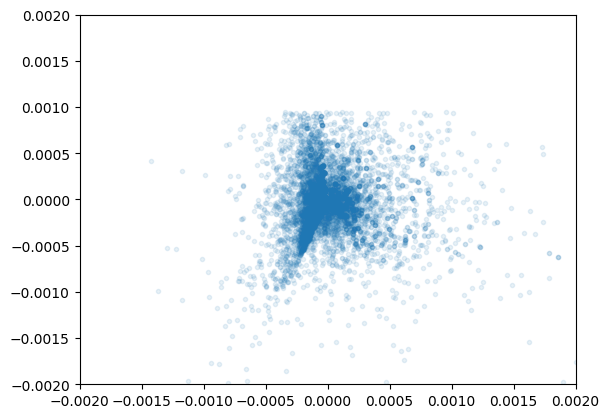

In [17]:
df_filtered = df_components[df_components[1]<(df_components[1].median()+.001)]
f,ax = plt.subplots(1,1)
ax.plot(df_filtered[0],df_filtered[1],'.',alpha=.1)
ax.set_xlim(-.002,0.002)
ax.set_ylim(-.002,0.002)

## 2.3 Overview of the compoenent II

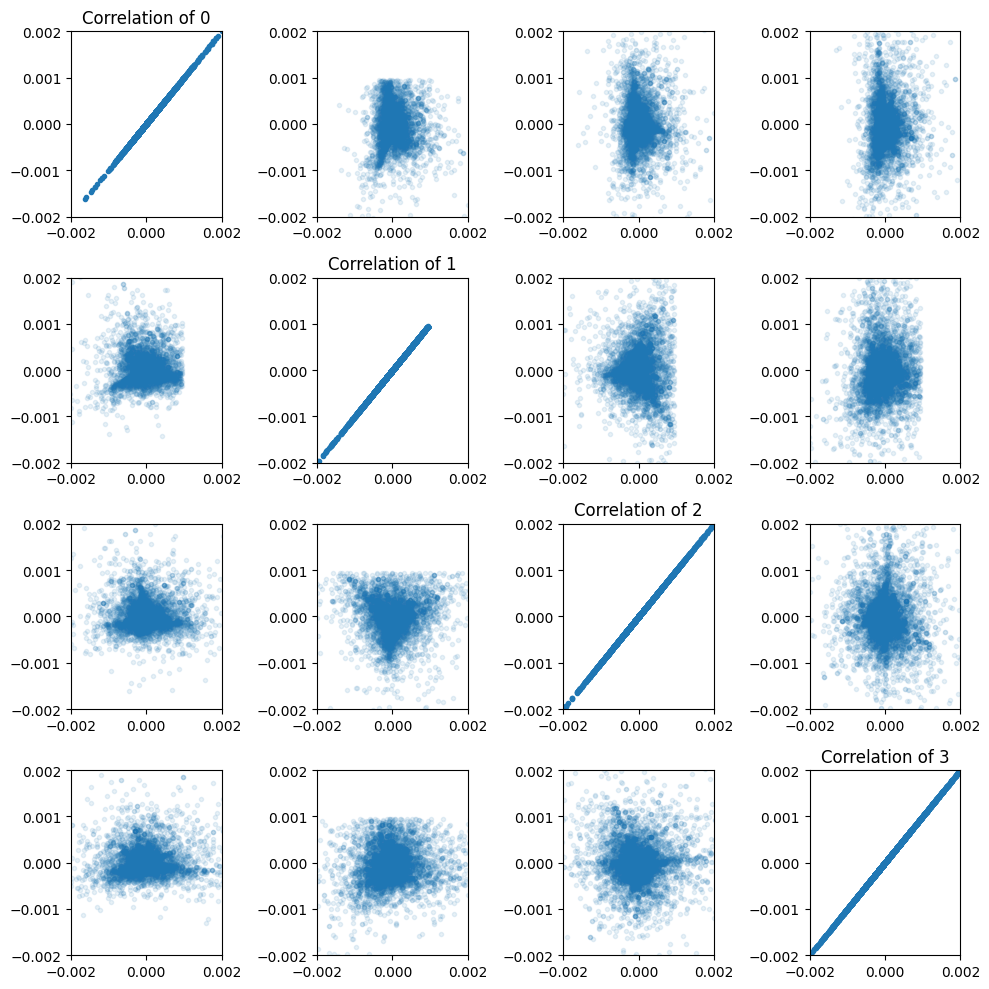

In [17]:
f, ax = plt.subplots(n_components, n_components, figsize=(10, 10))
axs = np.ravel(ax)


df_filtered = df_components[df_components[1] < (df_components[1].median() + .001)]


for i in range(n_components):
    for j in range(n_components):
        ax = axs[i * n_components + j]  # Select the correct subplot
        
        if i == j:
            # Plot the correlation line (diagonal)
            ax.plot(df_filtered[df_filtered.columns[i]], df_filtered[df_filtered.columns[j]], '.')
            ax.set_title(f'Correlation of {df_filtered.columns[i]}')
        else:
            # Plot the scatter plot for off-diagonal elements
            ax.plot(df_filtered[df_filtered.columns[i]], df_filtered[df_filtered.columns[j]], '.', alpha=0.1)
        
        ax.set_xlim(-.002, 0.002)
        ax.set_ylim(-.002, 0.002)

plt.tight_layout()

# 3. Dimensionality Reduction of the tfidf Matrix using TSNE
## T-distributed Stochastic Neighbor Embedding.

In [18]:
n_components = 2  # Number of components
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
tsne_result = tsne.fit_transform(tfidf_matrix_standardized)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [19]:
df_tsne = pd.DataFrame(tsne_result)
df_tsne.head()

,0,1
0,12.604378,-1.770895
1,-7.872846,-12.871529
2,3.016083,5.740948
3,13.723924,3.470645
4,-6.179663,-10.194491


## 3.3 Overview of the compoenent II

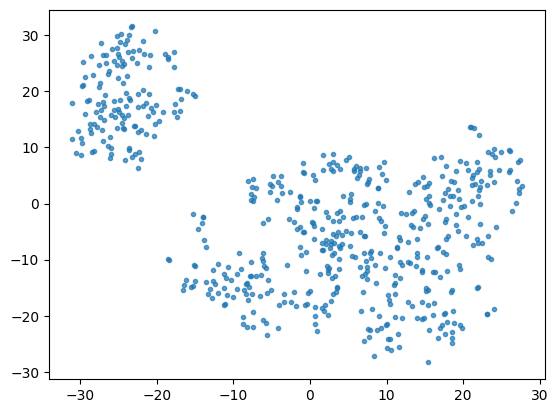

In [21]:
f,ax = plt.subplots(1,1)
ax.plot(df_tsne[0],df_tsne[1],'.',alpha=.7)

# 4. clustering

##  4.1 Apply Gaussian Mixture Models (GMM)

In [31]:
n_clusters = 8  # Number of clusters - we can change this according to the structure...
gmm = GaussianMixture(n_components=n_clusters, random_state=0)
gmm_labels = gmm.fit_predict(tsne_result)

In [32]:
df_tsne['GMM'] = gmm_labels

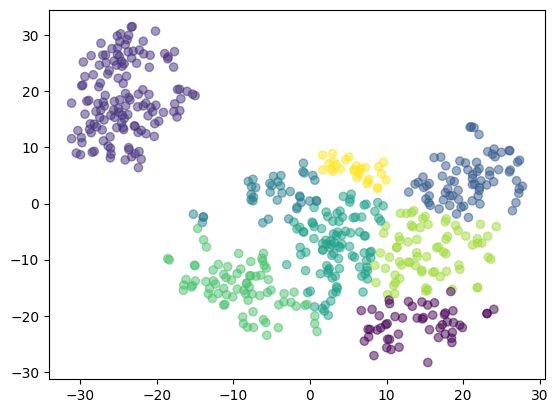

In [33]:
f,ax = plt.subplots(1,1)
ax.scatter(df_tsne[0],df_tsne[1],c=df_tsne['GMM'],cmap='viridis',alpha=.5)

##  4.2 Apply kmeans

In [34]:
n_clusters = 8  # Number of clusters 

kmeans = KMeans(n_clusters=n_clusters)  # Specify the number of clusters

# Fit the model to the TSNE Components
kmeans_labels = kmeans.fit_predict(tsne_result)
df_tsne['kmeans'] = kmeans_labels

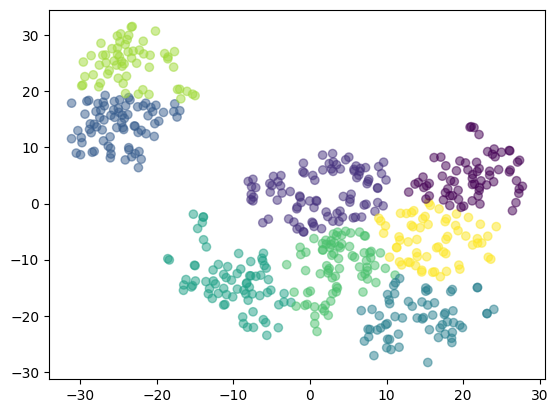

In [35]:
f,ax = plt.subplots(1,1)
ax.scatter(df_tsne[0],df_tsne[1],c=df_tsne['kmeans'],cmap='viridis',alpha=.5)

## Check if the clusters mean anything

In [117]:
for k in df_papers[df_tsne['kmeans'] ==1]['Title']:
    print(k)
    print("--------------------------------------")

Bridge damage: Detection, IFC-based semantic enrichment and visualization
--------------------------------------
Remote interactive collaboration in facilities management using BIM-based mixed reality
--------------------------------------
Building information modelling for off-site construction: Review and future directions
--------------------------------------
Software for processing and visualization of measurements of the deformation of the Earth's crust
--------------------------------------
Evaluation of Convolutional Neural Network Architectures for Chart Image Classification
--------------------------------------
A cloud-based flood warning system for forecasting impacts to transportation infrastructure systems
--------------------------------------
Implementation and evaluation of distributed graph sampling methods with spark
--------------------------------------
Choice of the regularization parameter for total variation image denoising using no-reference metric
------------

# 5. Use BERT (LLM) to label the clusters (instead of TF-IDF)
<img src='https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png' width=400px>

## 5.1 Load pre-trained BERT tokenizer and model

In [49]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')



# Tokenize and convert abstracts to BERT embeddings
embeddings = []

for abstract in abstracts:
    inputs = tokenizer(abstract, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())    
np.save('embeddings.npy', embeddings)

In [125]:
embeddings[0].shape

(768,)

## Embeddings

In [57]:
print(f"{len(embeddings)} x {embeddings[0].size} ")

570 x 768 


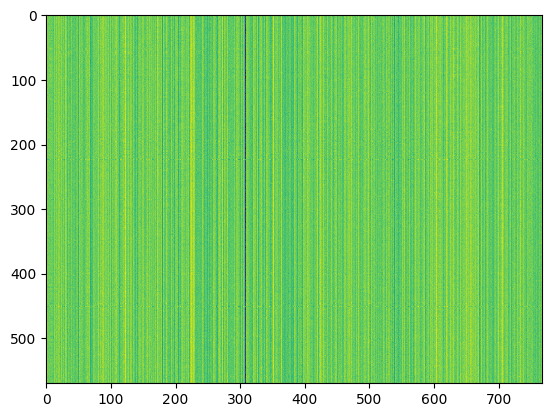

In [59]:
plt.imshow(embeddings, cmap='viridis', interpolation='nearest')

In [50]:
# Load embeddings from the file
# embeddings = np.load('embeddings.npy', allow_pickle=True)

## 5.2 Use Bert Embeddings to Classify

### Now 'embeddings' contains BERT embeddings for each abstract
### Apply PCA on Bert embeddings

In [94]:
# Apply PCA to reduce dimensions to 2D
n_components = 8
pca = PCA(n_components=4)
bert_pca = pca.fit_transform(embeddings)


In [126]:
bert_pca

array([[-2.03641032, -0.96562768,  0.40965087, ...,  1.28595838,
        -0.47086734, -0.26191243],
       [-2.05434762,  0.18162755, -0.76618709, ...,  0.3606118 ,
        -0.25533456,  0.58515721],
       [ 0.14907363,  0.23633513,  0.72337035, ..., -0.05025974,
         0.2870753 , -0.80299593],
       ...,
       [ 2.03419367,  0.6314765 , -0.35045545, ...,  0.33302661,
        -0.56170819,  0.14245265],
       [-0.19348698, -1.61495042,  0.99126767, ..., -0.77305372,
        -0.43610152,  0.39796445],
       [-0.00775241,  0.78374316,  0.09466385, ...,  0.27278296,
         0.12596908,  0.71884574]])

In [95]:
n_clusters = 8 
bert_pca_kmeans = KMeans(n_clusters=n_clusters)  # Specify the number of clusters
kmeans_labels = kmeans.fit_predict(bert_pca)

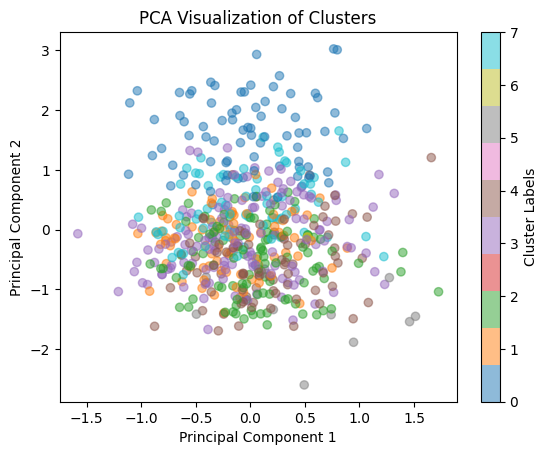

In [109]:
# Create a scatter plot of the 2D embeddings with cluster labels
plt.scatter(bert_pca[:, 7], bert_pca[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.5)
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Labels')
plt.show()

In [ ]:

# Create a scatter plot of the 2D embeddings with cluster labels
plt.scatter(bert_pca[:, 1], bert_pca[:, 0], c=kmeans_labels, cmap='tab10', alpha=0.5)
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Labels')
plt.show()

In [97]:
bert_pca

array([[-2.03641032, -0.96562768,  0.40965087, ...,  1.28595838,
        -0.47086734, -0.26191243],
       [-2.05434762,  0.18162755, -0.76618709, ...,  0.3606118 ,
        -0.25533456,  0.58515721],
       [ 0.14907363,  0.23633513,  0.72337035, ..., -0.05025974,
         0.2870753 , -0.80299593],
       ...,
       [ 2.03419367,  0.6314765 , -0.35045545, ...,  0.33302661,
        -0.56170819,  0.14245265],
       [-0.19348698, -1.61495042,  0.99126767, ..., -0.77305372,
        -0.43610152,  0.39796445],
       [-0.00775241,  0.78374316,  0.09466385, ...,  0.27278296,
         0.12596908,  0.71884574]])

# 6 Cosine Similarity on Embeddings

In [102]:
similarity_matrix = cosine_similarity(embeddings)
df_link_matrix = pd.DataFrame(similarity_matrix)

In [127]:
similarity_matrix

array([[1.0000002 , 0.8992723 , 0.867142  , ..., 0.79538226, 0.84705824,
        0.83375835],
       [0.8992723 , 1.0000004 , 0.8451909 , ..., 0.8123547 , 0.81758684,
        0.8548367 ],
       [0.867142  , 0.8451909 , 1.0000001 , ..., 0.87514466, 0.85579056,
        0.8669491 ],
       ...,
       [0.79538226, 0.8123547 , 0.87514466, ..., 1.0000002 , 0.8360593 ,
        0.86226165],
       [0.84705824, 0.81758684, 0.85579056, ..., 0.8360593 , 1.        ,
        0.83321023],
       [0.83375835, 0.8548367 , 0.8669491 , ..., 0.86226165, 0.83321023,
        1.        ]], dtype=float32)

## Apply scale on the similarities

In [103]:
df_link_matrix_scaled = pd.DataFrame(scaler.fit_transform(df_link_matrix), columns=df_link_matrix.columns)

## Overview data

In [104]:
df_link_matrix_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
0,2.507183,0.711114,-0.571417,-1.115986,-0.052673,0.581661,-0.167549,0.665035,0.657567,0.815748,...,-1.010681,0.569148,0.445035,0.319996,-0.862702,-0.253118,-0.932870,-1.485647,-0.256094,-1.108150
1,0.678065,2.760115,-1.278679,-0.486004,-0.116348,-0.510524,-0.192188,0.370170,-0.203165,-0.257812,...,-0.598965,1.097995,0.817105,-0.220586,-0.851861,-0.197787,-0.739137,-1.161605,-0.843386,-0.332265
2,0.094611,-0.389006,3.709249,-0.309304,0.687179,0.531446,0.929615,0.323963,0.785814,0.476744,...,-0.267631,-0.456877,-0.789181,-0.354584,-0.386168,-0.310078,-0.110794,0.037200,-0.082081,0.113587
3,0.190842,0.555546,0.390774,3.073057,0.663948,0.830105,0.253237,0.254683,0.180980,0.442438,...,0.390978,0.159385,0.791234,0.667540,0.821790,0.665873,0.527182,0.495865,0.334849,0.234978
4,0.385799,0.336659,0.811224,0.091525,3.163101,0.302965,0.824979,0.885393,0.519971,0.449893,...,-0.084995,-0.394269,0.183495,-0.159448,-0.435196,-0.231204,-0.285995,-0.383640,0.025790,0.810673


## Use networkX and a similarity threshold to build the network

In [32]:
# Create an empty undirected graph
G = nx.Graph()

# Define the threshold for creating edges
threshold = 1.5

# Iterate over rows and columns to add edges with weights
for i, source_node in enumerate(df_link_matrix_scaled.columns):
    for j, target_node in enumerate(df_link_matrix_scaled.columns):
        if i < j:  # Only consider the upper triangle of the matrix
            weight = df_link_matrix_scaled.iloc[i, j]
            if weight >= threshold:
                G.add_edge(source_node, target_node, weight=weight)

In [33]:


# Create an empty undirected graph
G = nx.Graph()

# Define the threshold for creating edges
threshold = 1.5

# Iterate over rows and columns to add edges with weights
for i in range(len(df_link_matrix_scaled.columns)):
    source_node = df_link_matrix_scaled.columns[i]
    
    # Ensure the node exists in the graph
    G.add_node(source_node)  # Add the node if not already added

    for j in range(i + 1, len(df_link_matrix_scaled.columns)):
        target_node = df_link_matrix_scaled.columns[j]
        weight = df_link_matrix_scaled.iloc[i, j]
        if weight >= threshold:
            G.add_edge(source_node, target_node, weight=weight)
            
    # Add the title as an attribute to each node
    G.nodes[source_node]['title'] = df_papers['Title'].iloc[i]

# Remove nodes with degree less than 2
for node in list(G.nodes):  # Convert to list to avoid modifying the graph while iterating
    if G.degree(node) < 2:
        G.remove_node(node)


## Export the network

In [34]:
# Specify the file path where you want to save the GEXF file
gexf_file_path = "Documents_graph.gexf"

# Export the graph to a GEXF file
nx.write_gexf(G, gexf_file_path)

<img src="./img/With_Labels.png"/>